# Distinguish Your Own Digits (DYOD)

You are going to write a classifier that distinguishes between the number 3 and number 8.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

From the command line run `pip install mnist`. This is a library that will help you bring down the mnist dataset. If you run this from a notebook, you need to put  `!pip install mnist` in a cell by itself.

In [3]:
!pip install mnist

## Preparing the Data

In [4]:
import mnist

In [5]:
train_images = mnist.train_images()
train_labels = mnist.train_labels()

In [6]:
train_images.shape, train_labels.shape

((60000, 28, 28), (60000,))

In [7]:
test_images = mnist.test_images()
test_labels = mnist.test_labels()

In [8]:
test_images.shape, test_labels.shape

((10000, 28, 28), (10000,))

2


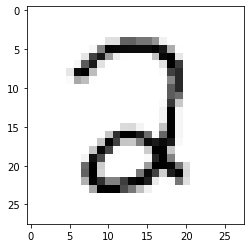

In [9]:
image_index = 7776 # You may select anything up to 60,000
print(train_labels[image_index]) 
plt.imshow(train_images[image_index], cmap='Greys')

## Filter data to get 3 and 8 out

In [10]:
train_filter = np.where((train_labels == 3 ) | (train_labels == 8))
test_filter = np.where((test_labels == 3) | (test_labels == 8))
X_train, y_train = train_images[train_filter], train_labels[train_filter]
X_test, y_test = test_images[test_filter], test_labels[test_filter]

We normalize the pizel values in the 0 to 1 range

In [11]:
X_train = X_train/255.
X_test = X_test/255.

And setup the labels as 1 (when the digit is 3) and 0 (when the digit is 8)

In [12]:
y_train = 1*(y_train==3)
y_test = 1*(y_test==3)

In [13]:
X_train.shape, X_test.shape

((11982, 28, 28), (1984, 28, 28))

We reshape the data to flatten the image pixels into a set of features or co-variates:

In [14]:
X_train = X_train.reshape(X_train.shape[0], -1)
X_test = X_test.reshape(X_test.shape[0], -1)
X_train.shape, X_test.shape

((11982, 784), (1984, 784))

In [15]:
#Impoting functions from 'Kudzu'
from kudzu.model import Model
from kudzu.train import Learner
from kudzu.optim import GD
from kudzu.data import Data, Sampler,Dataloader

from kudzu.callbacks import AccCallback
from kudzu.callbacks import ClfCallback

from kudzu.loss import MSE

from kudzu.layer import Sigmoid,Relu
from kudzu.layer import Affine

### Let us create a `Config` class, to store important parameters. 
This class essentially plays the role of a dictionary.

In [16]:
class Config:
    pass
config = Config()
config.lr = 0.001
config.num_epochs = 250
config.bs = 50

### Running Models with the Training data
Details about the network layers:
- A first affine layer has 784 inputs and does 100 affine transforms. These are followed by a Relu
- A second affine layer has 100 inputs from the 100 activations of the past layer, and does 100 affine transforms. These are followed by a Relu
- A third affine layer has 100 activations and does 2 affine transformations to create an embedding for visualization. There is no non-linearity here.
- A final "logistic regression" which has an affine transform from 2 inputs to 1 output, which is squeezed through a sigmoid.


In [17]:
data = Data(X_train, y_train.reshape(-1,1))
sampler = Sampler(data, config.bs, shuffle=True)

dl = Dataloader(data, sampler)

opt = GD(config.lr)
loss = MSE()

In [18]:
training_data_x = X_train
testing_data_x = X_test
training_data_y = y_train.reshape(-1,1)
testing_data_y = y_test.reshape(-1,1)

In [19]:
layers = [Affine("first", 784, 100), Relu("first"), Affine("second", 100, 100), Relu("second"), Affine("third", 100, 2), Affine("last", 2, 1), Sigmoid("last")]
model_nn = Model(layers)
model_lr = Model([Affine("logits", 784, 1), Sigmoid("sigmoid")])

xavier
xavier
xavier
xavier
xavier


In [20]:
nn_learner = Learner(loss, model_nn, opt, config.num_epochs)
acc_nn = ClfCallback(nn_learner, config.bs, training_data_x , testing_data_x, training_data_y, testing_data_y)
nn_learner.set_callbacks([acc_nn])

In [21]:
lr_learner = Learner(loss, model_lr, opt, config.num_epochs)
acc_lr = ClfCallback(lr_learner, config.bs, training_data_x , testing_data_x, training_data_y, testing_data_y)
lr_learner.set_callbacks([acc_lr])

In [22]:
nn_learner.train_loop(dl)

Epoch 0, Loss 0.2558
Training Accuracy: 0.4929, Testing Accuracy: 0.4945



Epoch 10, Loss 0.1427
Training Accuracy: 0.8988, Testing Accuracy: 0.9118



Epoch 20, Loss 0.0751
Training Accuracy: 0.9272, Testing Accuracy: 0.9370



Epoch 30, Loss 0.0541
Training Accuracy: 0.9436, Testing Accuracy: 0.9546



Epoch 40, Loss 0.0447
Training Accuracy: 0.9514, Testing Accuracy: 0.9592



Epoch 50, Loss 0.0395
Training Accuracy: 0.9551, Testing Accuracy: 0.9662



Epoch 60, Loss 0.0361
Training Accuracy: 0.9587, Testing Accuracy: 0.9672



Epoch 70, Loss 0.0337
Training Accuracy: 0.9604, Testing Accuracy: 0.9688



Epoch 80, Loss 0.0319
Training Accuracy: 0.9633, Testing Accuracy: 0.9688



Epoch 90, Loss 0.0304
Training Accuracy: 0.9646, Testing Accuracy: 0.9708



Epoch 100, Loss 0.0291
Training Accuracy: 0.9664, Testing Accuracy: 0.9728



Epoch 110, Loss 0.0281
Training Accuracy: 0.9673, Testing Accuracy: 0.9743



Epoch 120, Loss 0.0271
Training Accuracy: 0.9685, Testing Accuracy: 0.9748



Epoch 130, Loss 0.0263
Training Accuracy: 0.9694, Testing Accuracy: 0.9758



Epoch 140, Loss 0.0256
Training Accuracy: 0.9698, Testing Accuracy: 0.9753



Epoch 150, Loss 0.0249
Training Accuracy: 0.9705, Testing Accuracy: 0.9753



Epoch 160, Loss 0.0243
Training Accuracy: 0.9709, Testing Accuracy: 0.9753



Epoch 170, Loss 0.0237
Training Accuracy: 0.9719, Testing Accuracy: 0.9743



Epoch 180, Loss 0.0232
Training Accuracy: 0.9725, Testing Accuracy: 0.9748



Epoch 190, Loss 0.0227
Training Accuracy: 0.9731, Testing Accuracy: 0.9748



Epoch 200, Loss 0.0222
Training Accuracy: 0.9737, Testing Accuracy: 0.9748



Epoch 210, Loss 0.0217
Training Accuracy: 0.9745, Testing Accuracy: 0.9748



Epoch 220, Loss 0.0213
Training Accuracy: 0.9747, Testing Accuracy: 0.9748



Epoch 230, Loss 0.0209
Training Accuracy: 0.9753, Testing Accuracy: 0.9753



Epoch 240, Loss 0.0205
Training Accuracy: 0.9758, Testing Accuracy: 0.9753



0.027650359813194435

In [23]:
lr_learner.train_loop(dl)

Epoch 0, Loss 0.194
Training Accuracy: 0.8359, Testing Accuracy: 0.8564



Epoch 10, Loss 0.0972
Training Accuracy: 0.9165, Testing Accuracy: 0.9325



Epoch 20, Loss 0.0769
Training Accuracy: 0.9301, Testing Accuracy: 0.9466



Epoch 30, Loss 0.067
Training Accuracy: 0.9378, Testing Accuracy: 0.9501



Epoch 40, Loss 0.0609
Training Accuracy: 0.9419, Testing Accuracy: 0.9536



Epoch 50, Loss 0.0567
Training Accuracy: 0.9448, Testing Accuracy: 0.9567



Epoch 60, Loss 0.0535
Training Accuracy: 0.9473, Testing Accuracy: 0.9587



Epoch 70, Loss 0.051
Training Accuracy: 0.9489, Testing Accuracy: 0.9592



Epoch 80, Loss 0.049
Training Accuracy: 0.9511, Testing Accuracy: 0.9622



Epoch 90, Loss 0.0474
Training Accuracy: 0.9521, Testing Accuracy: 0.9642



Epoch 100, Loss 0.046
Training Accuracy: 0.9533, Testing Accuracy: 0.9647



Epoch 110, Loss 0.0448
Training Accuracy: 0.9544, Testing Accuracy: 0.9662



Epoch 120, Loss 0.0437
Training Accuracy: 0.9550, Testing Accuracy: 0.9647



Epoch 130, Loss 0.0428
Training Accuracy: 0.9553, Testing Accuracy: 0.9652



Epoch 140, Loss 0.042
Training Accuracy: 0.9564, Testing Accuracy: 0.9647



Epoch 150, Loss 0.0412
Training Accuracy: 0.9569, Testing Accuracy: 0.9647



Epoch 160, Loss 0.0405
Training Accuracy: 0.9576, Testing Accuracy: 0.9647



Epoch 170, Loss 0.0399
Training Accuracy: 0.9579, Testing Accuracy: 0.9642



Epoch 180, Loss 0.0394
Training Accuracy: 0.9584, Testing Accuracy: 0.9647



Epoch 190, Loss 0.0388
Training Accuracy: 0.9589, Testing Accuracy: 0.9652



Epoch 200, Loss 0.0384
Training Accuracy: 0.9596, Testing Accuracy: 0.9647



Epoch 210, Loss 0.0379
Training Accuracy: 0.9598, Testing Accuracy: 0.9647



Epoch 220, Loss 0.0375
Training Accuracy: 0.9600, Testing Accuracy: 0.9647



Epoch 230, Loss 0.0371
Training Accuracy: 0.9608, Testing Accuracy: 0.9647



Epoch 240, Loss 0.0368
Training Accuracy: 0.9610, Testing Accuracy: 0.9652



0.03173696644727027

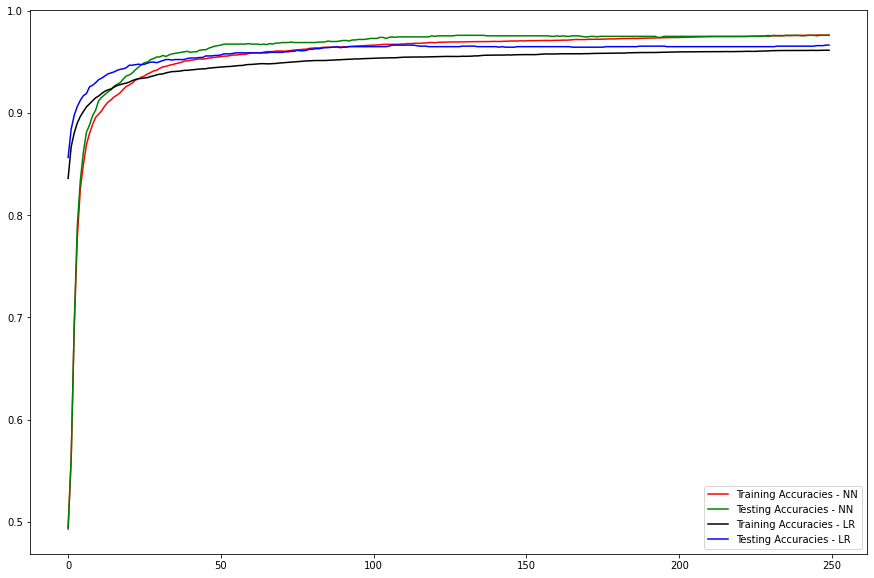

In [24]:
#comparing the results of NN and LR
plt.figure(figsize=(15,10))

# Neural Network plots
plt.plot(acc_nn.accuracies, 'r-', label = "Training Accuracies - NN")
plt.plot(acc_nn.test_accuracies, 'g-', label = "Testing Accuracies - NN")

# Logistic Regression plots
plt.plot(acc_lr.accuracies, 'k-', label = "Training Accuracies - LR")
plt.plot(acc_lr.test_accuracies, 'b-', label = "Testing Accuracies - LR")
plt.legend()

#### Plotting the outputs of this layer of the NN.


In [25]:
new_model = Model(layers[:-2])
testing_plot = new_model(testing_data_x)

Text(0.5, 1.0, 'Outputs')

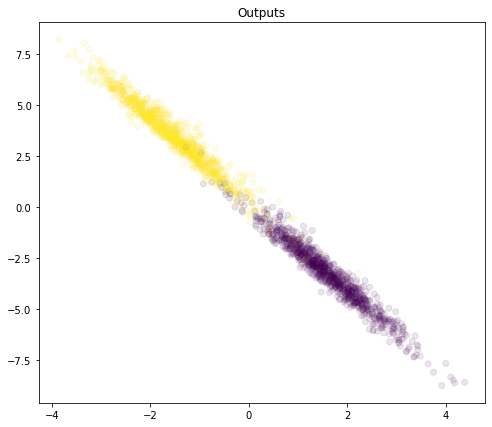

In [26]:
# Plotting the scatter plot of points and color coding by class
plt.figure(figsize=(8,7))
plt.scatter(testing_plot[:,0], testing_plot[:,1], alpha = 0.1, c = y_test.ravel());
plt.title('Outputs')

Probability contours

In [27]:
model_prob = Model(layers[-2:]) 

In [28]:
#creating the x and y ranges according to the above generated plot.
x_range = np.linspace(-4, 1, 100) 
y_range = np.linspace(-6, 6, 100) 
x_grid, y_grid = np.meshgrid(x_range, y_range) # x_grid and y_grig are of size 100 X 100

# converting x_grid and y_grid to continuous arrays
x_gridflat = np.ravel(x_grid)
y_gridflat = np.ravel(y_grid)

# The last layer of the current model takes two columns as input. Hence transpose of np.vstack() is required.
X = np.vstack((x_gridflat, y_gridflat)).T

prob_contour = model_prob(X).reshape(100,100) 

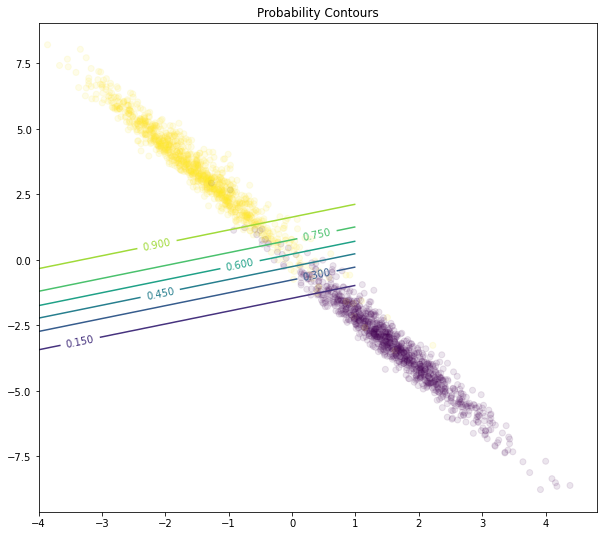

In [29]:
plt.figure(figsize=(10,9))
plt.scatter(testing_plot[:,0], testing_plot[:,1], alpha = 0.1, c = y_test.ravel())
contours = plt.contour(x_grid,y_grid,prob_contour)
plt.title('Probability Contours')
plt.clabel(contours, inline = True );